In [62]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as random
from numpy.linalg import pinv
%matplotlib inline

## 1. Implement a fixed network to solve the XOR operation, where the total number of neurons is 3 and the number of layers is 2. Use the batch gradient descent for the optimization.

In [63]:
class Layer(object):
    """
    Layer contains an array of neurons
    """
    
    def __init__(self, *args):
        self.weights = args[0]
        self.bias = args[1]
        """ gd: for gradient descent """
        self.bp2_gd = []
        self.bp3_gd = []
        self.bp4_gd = []
        self.a_gd = []
        
    def __call__(self, x):
        """ 
        Calling on the layer will calculate the output a of the activation function 
        and z, the intermediate calculation that sums the weights and bias
        
        x: list of inputs
        """
        self.z = self.basis_function(self.weights, self.bias, x)
        self.a = self.activation_function(self.sigmoid, self.z)
        return (self.z, self.a)
        
    def basis_function(self, w, b, x):
        z = w.T.dot(x) + b
        return z
    
    def sigmoid(self, a):
        return 1 / (1 + np.exp(-a))
    
    def activation_function(self, fun, z):
        return fun(z)

In [ ]:
class Network(object):
    """A Network contains a list of layers, and functions to do feedforward and backpropagation"""
    
    def __init__(self, *args):
        self.layers = []
        
        """
        a list of number of neurons in each layer
        i.e. [2, 2, 1] means that there are 2 neurons in the input layer and 2 in the first and 1 in the second layer
        """
        self.neuron_nums = args[0]
        # x: features to be trained
        self.x = args[1]
        # N: number of training data
        self.N = len(self.x)
        # t: result for comparison
        self.t = args[2]
        """ gd: for gradient descent"""
        self.bp1_gd = []
        self.error = []
        self.error_epoch = []
        
    def initialize_layers(self, neuron_nums, N):
        for i in range(len(neuron_nums) - 1): 
            self.initialize_layer(N, neuron_nums[i], neuron_nums[i+1])
    
    def initialize_layer(self, N, prev, curr, mu=0):
        """ 
        Initializes weights and bias for current layer
        N: number of training data
        prev: number of neurons in previous layer
        curr: number of neurons in current layer

        mu = 0
        sigma = 1 / sqrt(N) in order to avoid network saturation
        """
        mu = 0
        sigma = 1 / np.sqrt(N)

        W = np.zeros((curr, prev))
        b = np.zeros((curr, 1))
        for c in range(curr):
            b[c] = random.normal(mu, sigma)
            for p in range(prev):
                W[c][p] = random.normal(mu, sigma)

        layer = Layer(W.T, b)
        self.layers.append(layer)
    
    def feed_forward(self, layers, x, counter):
        """
        Start off with the first layer, where the input is x and the counter is 0. 
        Then we increase the counter and move to the next layer. 
        The output from the previous layer will become the input for the next layer.

        layers: list of layers in the network
        x: input to the layer
        counter: keep track of which layer we are in
        """
        layer = layers[counter] # get the current layer we are in
        z, a = layer(x) # calculate the value of a and z
        
        # checks whether we the number of z's is the same as the number of neurons in the layer
        assert z.shape == (self.neuron_nums[counter+1], 1)
        assert a.shape == (self.neuron_nums[counter+1], 1)
        
        layer.z = z # save the current value of z in the layer
        layer.a = a # save the current value of a in the layer
        layer.a_gd.append(a.T)
        if (counter==len(layers)-1):
            self.output = a
            return # if we have reached the last layer, return the output
        else:
            self.feed_forward(layers, layer.a, counter+1) # else keep feeding the result forward
    
    def back_prop1(self, layers, t):
        """ 
        Compute error of last layer
        """
        last_layer = layers[len(layers) - 1]
        a = last_layer.a
        z = last_layer.z
        t = t.reshape(a.shape)
        sigmoid = last_layer.sigmoid
        idx = np.argmax(t)
        self.error.append((a[idx] - 1)**2)
        assert a.shape==t.shape
        self.bp1 = np.multiply((a - t), np.multiply(sigmoid(z),(1 - sigmoid(z))))
        assert self.bp1.shape == (self.neuron_nums[len(layers)], 1)
        self.bp1_gd.append(self.bp1)
        
    def back_prop2(self, layers, counter, bp1):
        """ 
        Backpropagating the error 
        """
        if (counter<0):
            return
        
        """ 
        Setting up the parameters:
              From the current layer: z, sigmoid
              From the next layer: w, error 
        """
        current_layer = layers[counter]
        next_layer = layers[counter+1]
        sigmoid = current_layer.sigmoid
        z = current_layer.z
        w = next_layer.weights.T
        assert w.shape == (self.neuron_nums[counter+2], self.neuron_nums[counter+1])
        
        """ Calculating the error for that layer """
        current_layer.bp2 = np.multiply(w.T.dot(bp1), (np.multiply(sigmoid(z), (1 - sigmoid(z)))))
        current_layer.bp2_gd.append(current_layer.bp2)
        assert current_layer.bp2.shape == (self.neuron_nums[counter+1], 1)
        
        """ Recurse and pass the error back """
        self.back_prop2(layers, counter-1, current_layer.bp2)
    
    """ Computing the Gradients back_prop3 and back_prop4 """
    
    def back_prop3(self, layers, x, counter):
        if (counter<0):
            return
        
        """ Setting up the parameters """
        current_layer = layers[counter]
        if (counter==0): # if it is the first layer, 'a' comes from the input layer
            a = x
        else:
            prev_layer = layers[counter-1]
            a = prev_layer.a
        
        if (counter == len(layers) - 1): # if it is the last layer, get bp1
            bp2 = self.bp1
        else: 
            bp2 = current_layer.bp2
        
        current_layer.bp3 = bp2.dot(a.T)
        current_layer.bp3_gd.append(current_layer.bp3)
        assert current_layer.bp3.shape == (self.neuron_nums[counter+1], self.neuron_nums[counter])
        self.back_prop3(layers, x, counter-1)
        
    def back_prop4(self, layers, counter):
        if (counter < 0):
            return
        current_layer = layers[counter]
        if (counter == len(layers) - 1):
            current_layer.bp4 = self.bp1
            current_layer.bp4_gd.append(current_layer.bp4)
        else:
            current_layer.bp4 = current_layer.bp2
            current_layer.bp4_gd.append(current_layer.bp4)
        self.back_prop4(layers, counter-1)
    
    def __call__(self, x, t):
        """ Calling the network will ask it to predict """
        self.feed_forward(self.layers, x, 0)
        print (self.output)
        if (np.argmax(self.output)==0):
            print("Prediction: 0")
            print("Ground Truth: %s" % t)
        else:
            print("Prediction: 1")
            print("Ground Truth: %s" % t)
        
    
    def gradient_descent(self, layers, x, counter, alpha):
        """ alpha refers to the rate of learning """
        if (counter < 0):
            return
        
        """ Setting up the Parameters """
        current_layer = layers[counter]
        if (counter==0):
            a = x
        else:
            prev_layer = layers[counter-1]
            a = prev_layer.a_gd
            
        if (counter == len(layers) - 1): # if it is the last layer, get bp1
            bp2_gd = self.bp1_gd
        else: 
            bp2_gd = current_layer.bp2_gd
        
        w_old = current_layer.weights
        b_old = current_layer.bias
        
        """ Actual calculation for Gradient Descent """
        
        for i in range(50): # the number of times we want to run the gradient descent
            current_layer.bias = b_old - (alpha / self.N) * sum(bp2_gd)
            bp2 = []
            for n in range(len(bp2_gd)):
                bp2.append(bp2_gd[n].dot(a[n]))
            learning_weights = sum(bp2).T
            assert w_old.shape == ((alpha / self.N) * learning_weights).shape
            current_layer.weights = w_old - (alpha / self.N) * learning_weights
            
            b_old = current_layer.bias
            w_old = current_layer.weights
        
        self.gradient_descent(layers, x, counter-1, alpha)
        
    def refresh_network(self):
        layers = self.layers
        for l in layers:
            l.bp2_gd = []
            l.bp3_gd = []
            l.bp4_gd = []
            l.a_gd = []
        self.bp1_gd = []
        self.error = []

### Running the Network

In [48]:
x = np.asmatrix([[0, 0], [1, 0], [0, 1], [1, 1]])
t = np.asmatrix([[1, 0], [0, 1], [0, 1], [1, 0]])
neuron_nums = [2, 3, 2]

network = Network(neuron_nums, x, t)
network.initialize_layers(network.neuron_nums, network.N)

def train(x, t, neuron_nums):    
    for i in range(len(x)):
#         print("Training num: %s" % i)
        network.feed_forward(network.layers, network.x[i].T, 0)
        network.back_prop1(network.layers, t[i])
        network.back_prop2(network.layers, len(network.layers)-2, network.bp1)
        network.back_prop3(network.layers, network.x[i].T, len(network.layers)-1)
        network.back_prop4(network.layers, len(network.layers)-1)
    network.gradient_descent(network.layers, x, len(network.layers)-1, 0.5)
    network.error_epoch.append(np.mean(network.error))
#     print("Training complete!")

for i in range(200):
    train(x, t, neuron_nums)
    network.refresh_network()

## 2. Show the graph of the training process, where the x-axis represents the epoch, and the y-axis represents the overall error.

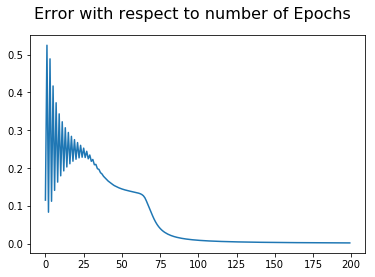

In [49]:
fig = plt.figure()
fig.suptitle("Error with respect to number of Epochs", fontsize=16)
x = np.arange(0, 200, 1)
plt.plot(x, network.error_epoch)
plt.show()

## 3. Verify your network in the testing stage, by giving any possible values as the input. Show both your prediction and the groundtruth.

In [50]:
network(np.array([0, 0]).reshape(2, 1), 0)
network(np.array([1, 0]).reshape(2, 1), 1)
network(np.array([0, 1]).reshape(2, 1), 1)
network(np.array([1, 1]).reshape(2, 1), 0)

[[ 0.98032401]
 [ 0.01936456]]
Prediction: 0
Ground Truth: 0
[[ 0.03716438]
 [ 0.96247816]]
Prediction: 1
Ground Truth: 1
[[ 0.04939443]
 [ 0.95031136]]
Prediction: 1
Ground Truth: 1
[[ 0.94776416]
 [ 0.05281813]]
Prediction: 0
Ground Truth: 0


## 4. Implement a flexible network to classify MNIST data. Use the mini-batch gradient descent for the optimization.

In [51]:
import mnist

train_images = mnist.train_images()
train_labels = mnist.train_labels()
test_images = mnist.test_images()
test_labels = mnist.test_labels()

ally = []
allx = []

numdata = len(train_images)
for idx in range(0, numdata, 1):
    allx.append(np.matrix(train_images[idx]))
    ally.append(np.matrix(train_labels[idx]))

ally = [[0 for col in range(10)] for row in range(len(ally))]
for idx in range(0, len(ally)):
    ally[idx][train_labels[idx]] = 1
allx = [x/255.0 for x in allx]

In [52]:
"""Format data such that all the images are 1 x 784 """
for i in range(len(allx)):
    allx[i] = allx[i].flatten()

### Training the Data

In [58]:
class MNISTNetwork(Network):
    def __init__(self, *args):
        self.layers = []
        
        """
        a list of number of neurons in each layer
        i.e. [2, 2, 1] means that there are 2 neurons in the input layer and 2 in the first and 1 in the second layer
        """
        self.neuron_nums = args[0]
        # x: features to be trained
        self.x = args[1]
        # N: number of training data
        self.N = len(self.x)
        # t: result for comparison
        self.t = args[2]
        """ gd: for gradient descent"""
        self.bp1_gd = []
        self.error = []
        self.error_epoch = []
        self.correct_predictions = 0
    
    def __call__(self, x, t):
        """ Calling the network will ask it to predict """
        self.feed_forward(self.layers, x, 0)
        print(self.output)
        prediction = np.argmax(self.output)
        ground_truth = np.argmax(t)
        print ("Prediction: %s" % prediction)
        print ("Ground Truth: %s" % ground_truth)
        if (prediction==ground_truth):
            self.correct_predictions += 1

In [ ]:
from random import randint
neuron_nums = [784, 100, 300, 10]

mnist_network = MNISTNetwork(neuron_nums, allx, ally)
mnist_network.initialize_layers(mnist_network.neuron_nums, mnist_network.N)
batch_size = 100

def train(x, t, neuron_nums):    
    for i in range(len(x)):
#         print("Training num: %s" % i)
        mnist_network.feed_forward(mnist_network.layers, mnist_network.x[i].T, 0)
        mnist_network.back_prop1(mnist_network.layers, np.array(t[i]))
        mnist_network.back_prop2(mnist_network.layers, len(mnist_network.layers)-2, mnist_network.bp1)
        mnist_network.back_prop3(mnist_network.layers, mnist_network.x[i].T, len(mnist_network.layers)-1)
        mnist_network.back_prop4(mnist_network.layers, len(mnist_network.layers)-1)
    mnist_network.gradient_descent(mnist_network.layers, x, len(mnist_network.layers)-1, 0.5)
    mnist_network.error_epoch.append(np.mean(mnist_network.error))
#     print("Training complete!")

for i in range(1):
    idx = randint(0, mnist_network.N - batch_size)
    batchx = allx[idx: idx+batch_size]
    batchy = ally[idx:idx+batch_size]
    train(batchx, batchy, neuron_nums)
    mnist_network.refresh_network()

### Plotting the Error

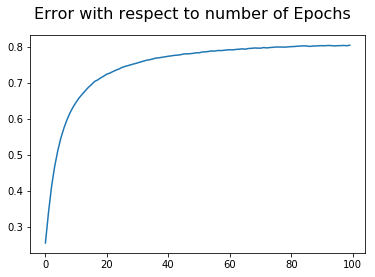

In [55]:
fig = plt.figure()
fig.suptitle("Error with respect to number of Epochs", fontsize=16)
x = np.arange(0, 100, 1)
plt.plot(x, mnist_network.error_epoch)
plt.show()

### Testing the Data

#### Formatting the testing data

In [56]:
testx = []
testy = []
num_test_data = len(test_images)
for idx in range(0, num_test_data, 1):
    testx.append(np.matrix(test_images[idx]))
    testy.append(np.matrix(test_labels[idx]))

testy = [[0 for col in range(10)] for row in range(len(testy))]
for idx in range(0, len(testy)):
    testy[idx][test_labels[idx]] = 1
testx = [x/255.0 for x in testx]

In [57]:
for i in range(len(testx)):
    mnist_network(testx[i].reshape(784, 1), testy[i])

Prediction: 1
Ground Truth: 7
Prediction: 1
Ground Truth: 2
Prediction: 1
Ground Truth: 1
Prediction: 1
Ground Truth: 0
Prediction: 1
Ground Truth: 4
Prediction: 1
Ground Truth: 1
Prediction: 1
Ground Truth: 4
Prediction: 1
Ground Truth: 9
Prediction: 1
Ground Truth: 5
Prediction: 1
Ground Truth: 9
Prediction: 1
Ground Truth: 0
Prediction: 1
Ground Truth: 6
Prediction: 1
Ground Truth: 9
Prediction: 1
Ground Truth: 0
Prediction: 1
Ground Truth: 1
Prediction: 1
Ground Truth: 5
Prediction: 1
Ground Truth: 9
Prediction: 1
Ground Truth: 7
Prediction: 1
Ground Truth: 3
Prediction: 1
Ground Truth: 4
Prediction: 1
Ground Truth: 9
Prediction: 1
Ground Truth: 6
Prediction: 1
Ground Truth: 6
Prediction: 1
Ground Truth: 5
Prediction: 1
Ground Truth: 4
Prediction: 1
Ground Truth: 0
Prediction: 1
Ground Truth: 7
Prediction: 1
Ground Truth: 4
Prediction: 1
Ground Truth: 0
Prediction: 1
Ground Truth: 1
Prediction: 1
Ground Truth: 3
Prediction: 1
Ground Truth: 1
Prediction: 1
Ground Truth: 3
Prediction

### Importing CIFAR10 dataset

In [ ]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

batch_1 = unpickle('cifar-10-batches-py/data_batch_1')
b1_data = batch_1['data']
b1_labels = batch_1['labels']

